PACKAGES

In [ ]:
pip install sentence_transformers

In [238]:
import json
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.model_selection import train_test_split

In [239]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
#import tensorflow_addons as tfa
import sklearn as sk
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [240]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocessing data

In [ ]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]
path_to_training = Path("/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/training")
path_to_test = Path("/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/test")

In [ ]:
#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])
#####
# text_baseline: utterances are embedded with SentenceTransformer, then train a DL classifier.
#####
from sklearn.tree import DecisionTreeClassifier
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('all-MiniLM-L6-v2')

y_training = []
with open("/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/training_labels.json", "r") as file:
    training_labels = json.load(file)
X_training = []
for transcription_id in training_set:
    with open(path_to_training / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)

    for utterance in transcription:
        X_training.append(utterance["speaker"].lower() + ": " + utterance["text"].lower())

    y_training += training_labels[transcription_id]


In [ ]:
#For the next time, I must clean the data

### Data Cleaning

In [241]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from wordcloud import WordCloud

In [ ]:
X_true = [X_training[i] for i in range(len(X_training)) if y_training[i] == 1]
X_false = [X_training[i] for i in range(len(X_training)) if y_training[i] == 0]
X_true

Visualising vocal sound

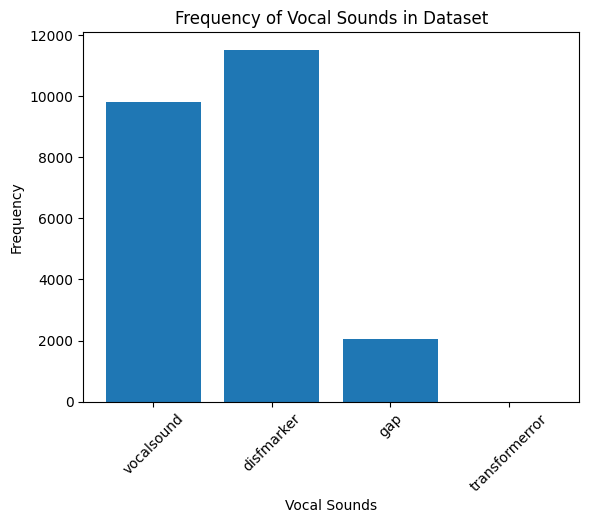

In [243]:

# Extract vocal sounds from each sentence
vocal_sounds = []
for sentence in X_training:
    found_sounds = re.findall(r"<(.*?)>", sentence)
    vocal_sounds.extend(found_sounds)

# Count the frequency of each vocal sound
sound_counts = Counter(vocal_sounds)

# Unpack the sounds and their counts
sounds, counts = zip(*sound_counts.items())

# Create a bar chart
plt.bar(sounds, counts)
plt.xlabel('Vocal Sounds')
plt.ylabel('Frequency')
plt.title('Frequency of Vocal Sounds in Dataset')
plt.xticks(rotation=45)
plt.show()


Word frequency distribution

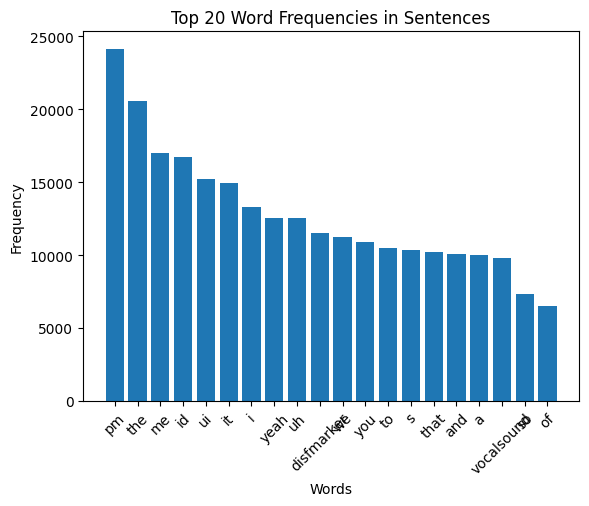

In [244]:

# Example array of sentences
sentences = ["This is a sentence.", "Another sentence with different words.", "Yet another sentence."]

# Split sentences into words and count frequency
word_counts = Counter(word for sentence in X_training for word in re.findall(r'\w+', sentence))

# Plotting
top = 20
words, counts = zip(*word_counts.most_common(20))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title(f'Top {top} Word Frequencies in Sentences')
plt.show()


Sentence length distribution

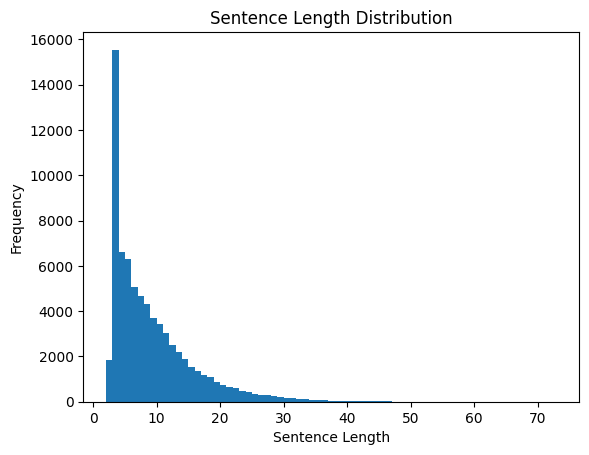

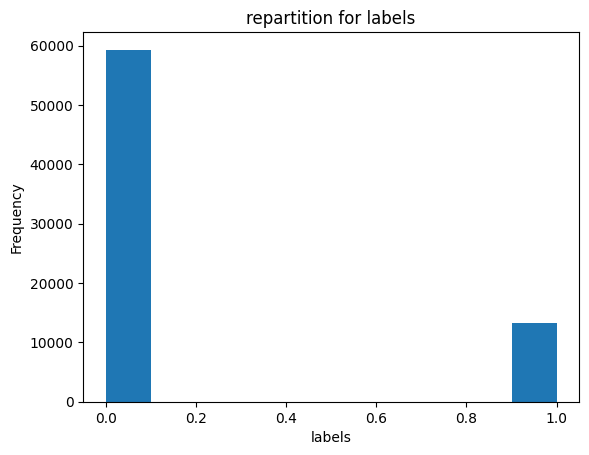

In [245]:
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in X_training]

# Plot histogram
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 1, 1))
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.show()
#plot label repartition
plt.hist(y_training)
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.title('repartition for labels')
plt.show()

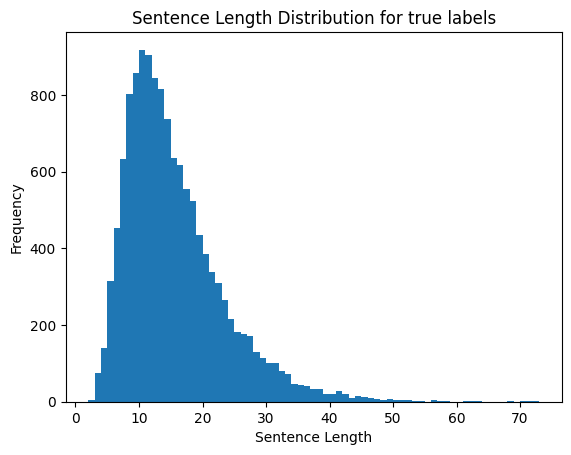

In [246]:
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in X_true]

# Plot histogram
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 1, 1))
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution for true labels')
plt.show()


In [ ]:
X_true[np.argmin(sentence_lengths)]

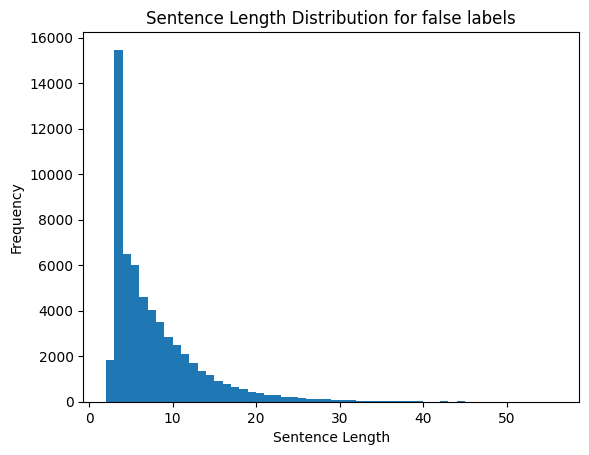

In [ ]:
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in X_false]

# Plot histogram
plt.hist(sentence_lengths, bins=range(min(sentence_lengths), max(sentence_lengths) + 1, 1))
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution for false labels')
plt.show()

Words cloud

Bigram frequency

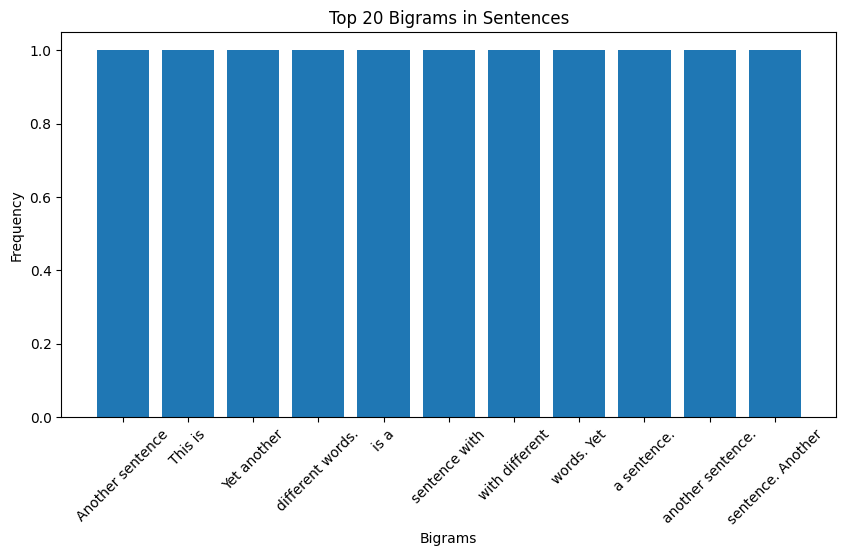

In [ ]:
from nltk import bigrams
from nltk.collocations import *

# Create bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word for sentence in sentences for word in sentence.split())

# Choose top 20 bigrams
top_bigrams = finder.nbest(bigram_measures.pmi, 20)

# Plotting
plt.figure(figsize=(10,5))
plt.bar(range(len(top_bigrams)), [finder.ngram_fd[bigram] for bigram in top_bigrams], tick_label=[f'{w1} {w2}' for w1, w2 in top_bigrams])
plt.xticks(rotation=45)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Top 20 Bigrams in Sentences')
plt.show()

Remove vocal sound

In [247]:
# Example array of sentences
# ANSI escape code for green text
GREEN = '\033[92m'  # This is for light green
RESET = '\033[0m'  # Reset to default color
RED = '\033[91m'  # This is for light red
RESET = '\033[0m'

# Function to remove vocal sounds from a sentence
def remove_vocal_sounds(sentence):   # Remove vocal sounds
    return re.sub(r"<[^>]*>", "", sentence)



# Remove vocal sounds from each sentence in the array
cleaned_sentences = [remove_vocal_sounds(sentence) for sentence in X_training]


Remove idiomatic sounds

In [ ]:
idiomatic_sounds = ["um", "ah", "uh", "you know", "like", "so", "actually", "basically", "seriously", "literally", "well", "really"]
def remove_idiomatic_sounds(sentence, sounds):
    for sound in sounds:
        sentence = sentence.replace(sound, "")
    return sentence
cleaned_sentences = [remove_idiomatic_sounds(sentence, idiomatic_sounds) for sentence in cleaned_sentences]

print(cleaned_sentences)

['pm: okay', 'pm: right', 'pm:    this is the kick-off meeting for our our project .', 'pm:   and ', "pm: this is just what we're gonna be doing over the next twenty five minutes .", 'pm:   first of all , just to kind of make sure that we all know each other ,', "pm: i'm laura and i'm the project manager .", 'pm:  do you want to introduce yourself again ?', 'me: great .', "id: hi , i'm david and i'm supposed to be an industrial designer .", 'pm: okay .', "me: and i'm andrew and i'm  our marketing", "ui:  i'm craig and i'm user interface .", 'me: expert .', 'pm: great .', 'pm: okay .  ', "pm:  we're designing a new remote control and  ", "pm: oh i have to record who's here  .", "pm:  that's david , andrew and craig , isn't it ?", 'pm: and you all arrived on time .', 'pm:  ye  des   design a new remote control .', "pm:  , as you can see it's supposed to be original , trendy and user friendly .", "pm:   that's kind of our our brief , as it were .", 'pm:  and  there are three different sta

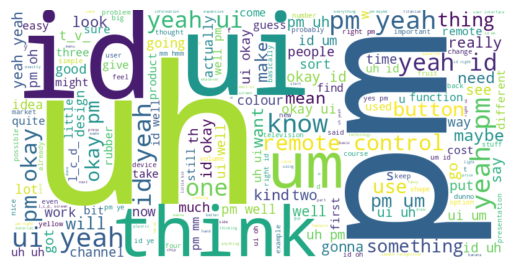

In [248]:
# Joining all sentences into a single text
all_text = ' '.join(cleaned_sentences)

# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
for i in range(50):
  if y_training[i] == 1:
    print(GREEN+cleaned_sentences[i]+RESET)
  else:
    print(RED+cleaned_sentences[i]+RESET)

In [ ]:
print(X_true)

['pm: <vocalsound> um well this is the kick-off meeting for our our project .', "pm: so we're designing a new remote control and um <disfmarker>", "pm: um , as you can see it's supposed to be original , trendy and user friendly .", 'pm: um and so there are three different stages to the design .', "pm: so we're gonna have like individual work and then a meeting about it .", 'pm: and repeat that process three times .', 'pm: <vocalsound> so uh you get to draw your favourite animal and sum up your favourite characteristics of it .', 'me: my favourite animal is like <disfmarker>', 'me: a beagle .', 'me: uh , right , well basically um high priority for any animal for me is that they be willing to take a lot of physical affection from their family .', 'me: and , yeah that they have lots of personality', 'ui: well , my favourite animal would be a monkey .', "ui: then they're small cute and furry ,", 'id: and i kind of like whales .', 'id: they come in and go <vocalsound> eat everything in sigh

### NN Model

In [249]:
X_encode = bert.encode(cleaned_sentences, show_progress_bar=True)

Batches:   0%|          | 0/2270 [00:00<?, ?it/s]

In [250]:
X_encode.shape[1]

384

Addressing unbalanced dataset

In [251]:
X_train = np.array(X_encode)
y_train = np.array(y_training)


In [252]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'y_train' contains your training labels
# And it's a binary or multiclass label encoded as integers
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
class_weights_dict

{0: 0.6120156410645362, 1: 2.7318311766476078}

In [253]:
from keras.regularizers import l1, l2

In [266]:
num_classes = 2

model = Sequential([
  layers.Dense(128, activation='relu', input_shape=(X_encode.shape[1],)),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu',),
  #layers.Dropout(0.5),
  #layers.Dense(16, activation='relu'),
  #layers.Dropout(0.5),
  #layers.Dense(8, activation='relu'),
  layers.Dense(2,activation='softmax' )
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
#

In [267]:
##SMOTE to adress umbalanced issues

In [272]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [273]:
epochs=5

history = model.fit(X_train, y_train, validation_split=0.2 , epochs=epochs) # class_weight=class_weights_dict

Epoch 1/5
927/927 [==============================] - 4s 4ms/step - loss: 0.3095 - accuracy: 0.8488 - val_loss: 0.3108 - val_accuracy: 0.8524
Epoch 2/5
927/927 [==============================] - 5s 5ms/step - loss: 0.3034 - accuracy: 0.8537 - val_loss: 0.3091 - val_accuracy: 0.8523
Epoch 3/5
927/927 [==============================] - 4s 4ms/step - loss: 0.2975 - accuracy: 0.8573 - val_loss: 0.3099 - val_accuracy: 0.8498
Epoch 4/5
927/927 [==============================] - 3s 4ms/step - loss: 0.2909 - accuracy: 0.8597 - val_loss: 0.3153 - val_accuracy: 0.8458
Epoch 5/5
927/927 [==============================] - 3s 4ms/step - loss: 0.2851 - accuracy: 0.8653 - val_loss: 0.3156 - val_accuracy: 0.8467


In [274]:
y_pred = np.argmax(model.predict(X_dev), axis =1)

497/497 [==============================] - 1s 2ms/step


In [275]:
from sklearn.metrics import f1_score
f1_score(y_dev, y_pred, average = 'binary')

0.573595810005418

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_dev, labels=[0, 1])

array([[4003,  143],
       [1854, 1208]])

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
counts

array([14882,  9084])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_labels = {}
X_test = []
for transcription_id in test_set:
    with open(path_to_test / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)
    for utterance in transcription:
        X_test.append(utterance["speaker"] + ": " + utterance["text"])
X_test = bert.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/970 [00:00<?, ?it/s]

In [ ]:
y_test = np.argmax(model.predict(X_test), axis =1)
y_test

970/970 [==============================] - 5s 5ms/step


array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/inf554-extractive-summarization-2023/test_labels_naive_baseline.json', 'r') as file:
    data_dict = json.load(file)
print(data_dict)

{'ES2003a': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'ES2003b': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Submission routine

In [ ]:
id = []
for keys in test_set:
  for i in range(len(data_dict[keys])):
    id.append(keys+"_"+str(i))
id

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(columns=['id', 'target_feature'])
df['id'] = id
df["target_feature"] = y_test
df.head()

id  target_feature
0  ES2003a_0               0
1  ES2003a_1               0
2  ES2003a_2               0
3  ES2003a_3               0
4  ES2003a_4               0

In [ ]:
df.to_csv('test_labels_text_DL_3.csv', index=False, encoding='utf-8')